In [3]:
!pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install opencv-python-headless

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 812.7 kB/s eta 0:00:48
    --------------------------------------- 0.5/38.8 MB 4.8 MB/s eta 0:00:08
    --------------------------------------- 0.8/38.8 MB 5.1 MB/s eta 0:00:08
   - -------------------------------------- 1.0/38.8 MB 4.7 MB/s eta 0:00:08
   - -------------------------------------- 1.1/38.8 MB 4.6 MB/s eta 0:00:09
   - -------------------------------------- 1.1/38.8 MB 4.6 MB/s eta 0:00:09
   - -------------------------------------- 1.1/38.8 MB 4.6 MB/s eta 0:00:09
   - -------------------------------------- 1.7/38.8 MB 4.3 MB/s eta 0:00:09
   - -------------------------------------- 1.9/38.8 MB 4.2 MB/s eta 0:00:09
   -- ------------------------------------- 2.1/38.8 MB 4.3 MB/s eta 0:00:09
   -- ------------------------------------- 2.2/38.8 MB 4.2 MB/s eta 0:00:09
   -- -----


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


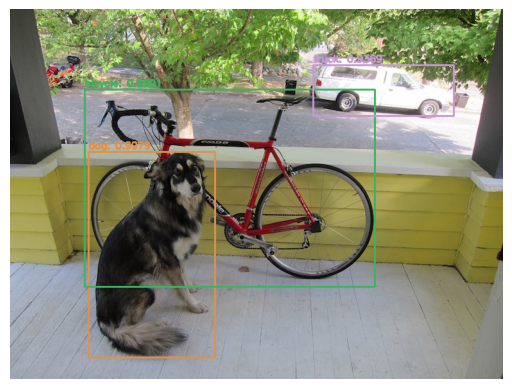

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to YOLO files
yolo_weights = 'yolov3.weights'  # Replace with your actual path
yolo_cfg = 'yolov3.cfg'          # Replace with your actual path
coco_names = 'coco.names'        # Replace with your actual path

# Load YOLO
net = cv2.dnn.readNet(yolo_weights, yolo_cfg)

# Load class names
with open(coco_names, 'r') as f:
    class_names = f.read().strip().split('\n')

# Assign colors to each class
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype='uint8')

# Path to the image
image_path = 'dog_bike_car.jpg'  # Ensure this is the correct path to the image

# Load and check the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from path {image_path}")
else:
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get output layer names
    layer_names = net.getLayerNames()
    output_layers_indices = net.getUnconnectedOutLayers()
    output_layers = [layer_names[i - 1] for i in output_layers_indices]

    # Perform detection
    detections = net.forward(output_layers)

    # Initialize lists for detected bounding boxes, confidences, and class IDs
    boxes = []
    confidences = []
    class_ids = []

    # Loop over detections and filter based on confidence threshold
    for output in detections:
        for detection in output:
            # Assuming detection is a flat array of detections
            num_detections = detection.shape[0] // 85  # Number of detections
            for i in range(num_detections):
                obj = detection[i * 85:(i + 1) * 85]  # Extract each detection
                scores = obj[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > 0.5:
                    centerX, centerY, w, h = obj[0:4] * np.array([width, height, width, height])
                    x = int(centerX - (w / 2))
                    y = int(centerY - (h / 2))

                    boxes.append([x, y, int(w), int(h)])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

    # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes on the image
    if len(indices) > 0:
        indices = indices.flatten()
        for i in indices:
            box = boxes[i]
            (x, y, w, h) = box
            color = [int(c) for c in colors[class_ids[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(class_names[class_ids[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
